## Train a neural network to learn and predict spiral dataset class. Moreover like classification model.

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import random_split, TensorDataset, DataLoader

In [2]:
seed = 123
dtype = torch.float32
device = 'cuda' if torch.cuda.is_available() else 'cpu' 
torch.set_default_device(device)
torch.manual_seed(seed)
generator = torch.Generator(device=device).manual_seed(seed)

In [3]:
def generate_spiral_data(points_per_class=100, num_classes=3, noise=0.2):
    X = np.zeros((points_per_class * num_classes, 2))  
    y = np.zeros(points_per_class * num_classes, dtype='uint8') 

    for j in range(num_classes):
        ix = range(points_per_class * j, points_per_class * (j + 1))
        r = np.linspace(0.0, 1, points_per_class)  # radius
        t = np.linspace(j * 4, (j + 1) * 4, points_per_class) + np.random.randn(points_per_class) * noise
        X[ix] = np.c_[r * np.sin(t * 2.5), r * np.cos(t * 2.5)]
        y[ix] = j

    return X, y

X_dataset, y_dataset = generate_spiral_data(points_per_class=500, num_classes=3, noise=0.05)
X_dataset = torch.tensor(X_dataset, dtype=torch.float32).to(device)
y_dataset = torch.tensor(y_dataset).to(device)

dataset = TensorDataset(X_dataset, y_dataset)
total_size = len(dataset)

train_size = int(total_size * 0.6)
val_size = int(total_size * 0.2)
test_size = int(total_size * 0.2)

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size], generator=generator)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, generator=generator)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True, generator=generator)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True, generator=generator)  

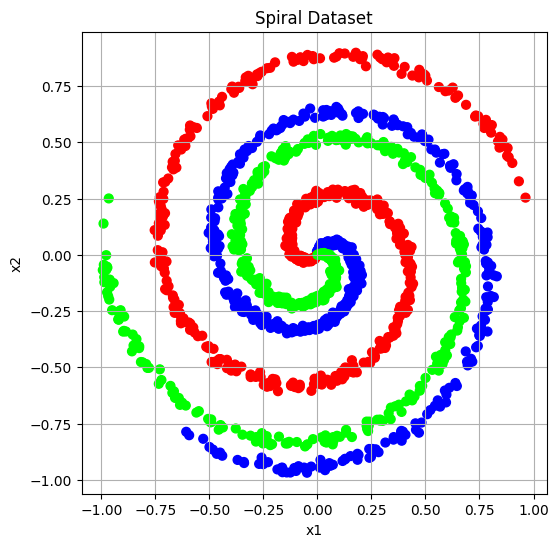

In [4]:
def plot_classification_data(X, y):
    plt.figure(figsize=(6,6))
    plt.scatter(X.cpu()[:, 0], X.cpu()[:, 1], c=y.cpu(), cmap="brg", s=40)
    plt.title("Spiral Dataset")
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.grid(True)
    plt.show()

plot_classification_data(X_dataset, y_dataset)

In [5]:
class SpiralModel(nn.Module):
    
    def __init__(self, input_size, output_size):
        super(SpiralModel, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, output_size)
        )

    def forward(self, input):
        return self.layers(input)

In [6]:
epoch = 200
print_per_epoch = 10

def accuracy(model, test_loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for _, data in enumerate(test_loader):
            inputs, labels = data
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)  
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    return correct / total

def eval(model, loss_fn, val_loader):
    running_loss = 0
    model.eval()

    with torch.no_grad():
        for _, data in enumerate(val_loader):
            inputs, labels = data

            y_pred = model(inputs)

            loss = loss_fn(y_pred, labels)
            running_loss += loss.item()
    return running_loss / len(val_loader)


def train(model, loss_fn, optimizer, train_loader, val_loader):
    model.train()

    for i in range(epoch):
        running_loss = 0
        for _, data in enumerate(train_loader):
            inputs, labels = data

            optimizer.zero_grad()

            y_pred = model(inputs)
            loss = loss_fn(y_pred, labels)
            running_loss += loss.item()

            loss.backward()

            optimizer.step()
        train_loss_avg = running_loss / len(train_loader)
        val_loss_avg = eval(model, loss_fn, val_loader)
        
        if (i+1)%print_per_epoch == 0:
            print('LOSS train {} valid {}'.format(train_loss_avg, val_loss_avg))

In [7]:
input_size = 2
output_size = 3
learning_rate = 1e-3

model = SpiralModel(input_size, output_size)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

train(model, criterion, optimizer, train_loader, val_loader)
acc = accuracy(model, test_loader)

print('ACC {}'.format(acc))

LOSS train 0.9773518545874234 valid 0.9386606454849243
LOSS train 0.7549915724787218 valid 0.7596516609191895
LOSS train 0.5389702813378696 valid 0.539724811911583
LOSS train 0.39656274534504987 valid 0.41567344069480894
LOSS train 0.30534164145075043 valid 0.31335159540176394
LOSS train 0.2263986175430232 valid 0.2224046379327774
LOSS train 0.19155100090750332 valid 0.19451891630887985
LOSS train 0.15595257487790337 valid 0.13892701268196106
LOSS train 0.12858958747880211 valid 0.11975083276629447
LOSS train 0.10625252230414028 valid 0.0851093027740717
LOSS train 0.08958788270708816 valid 0.08274030536413193
LOSS train 0.07813915276321871 valid 0.06912608668208123
LOSS train 0.0672893318636664 valid 0.05341076236218214
LOSS train 0.05905221633870026 valid 0.04568336196243763
LOSS train 0.056140034042041875 valid 0.0412782359868288
LOSS train 0.04850317955274006 valid 0.03542465791106224
LOSS train 0.045783211605559135 valid 0.032146979961544274
LOSS train 0.04735773050322615 valid 0.0